In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from itertools import cycle
import gc

plt.style.use("ggplot")
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

In [2]:
# reading the train data set
# using the robiks cube data/Rob Mulla
train = pd.read_parquet('/kaggle/input/ubiquant-parquet/train_low_mem.parquet')

In [3]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                #if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                #    df[col] = df[col].astype(np.float16)
                #elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                #    df[col] = df[col].astype(np.float32)
                #else:
                df[col] = df[col].astype(np.float16)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [4]:
# call the memory reduction function
train = reduce_mem_usage(train)

Memory usage of dataframe is 3642.99 MB
Memory usage after optimization is: 1915.96 MB
Decreased by 47.4%


In [5]:
# the first five rows of the df

train.head(5)

,row_id,time_id,investment_id,target,f_0,f_1,f_2,f_3,f_4,f_5,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
0,0_1,0.0,1.0,-0.300781,0.932617,0.113708,-0.402100,0.378418,-0.203979,-0.413574,...,0.365967,-1.095703,0.200073,0.819336,0.941406,-0.086792,-1.086914,-1.044922,-0.287598,0.321533
1,0_2,0.0,2.0,-0.231079,0.811035,-0.514160,0.742188,-0.616699,-0.194214,1.771484,...,-0.154175,0.912598,-0.734375,0.819336,0.941406,-0.387695,-1.086914,-0.929688,-0.974121,-0.343506
2,0_6,0.0,6.0,0.568848,0.394043,0.615723,0.567871,-0.607910,0.068909,-1.083008,...,-0.138062,0.912598,-0.551758,-1.220703,-1.060547,-0.219116,-1.086914,-0.612305,-0.113953,0.243652
3,0_7,0.0,7.0,-1.064453,-2.343750,-0.011871,1.875000,-0.606445,-0.586914,-0.815918,...,0.382080,0.912598,-0.266357,-1.220703,0.941406,-0.608887,0.104919,-0.783203,1.151367,-0.773438
4,0_8,0.0,8.0,-0.531738,0.842285,-0.262939,2.330078,-0.583496,-0.618164,-0.742676,...,-0.170410,0.912598,-0.741211,-1.220703,0.941406,-0.588379,0.104919,0.753418,1.345703,-0.737793


In [6]:
# unique investment ids
investment_id = 'investment_id'
train[investment_id].nunique()

2788

In [7]:
# find the shape of the data
train.shape

(3141410, 304)

In [8]:
train.describe()

,time_id,investment_id,target,f_0,f_1,f_2,f_3,f_4,f_5,f_6,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
count,3141410.0,3141410.0,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,...,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06
mean,NaN,NaN,NaN,1.633644e-03,-1.258850e-02,8.499146e-03,-1.992798e-02,-5.428314e-03,-3.021240e-03,1.940727e-03,...,1.258850e-02,8.964539e-04,-6.500244e-03,2.836227e-03,-4.730225e-03,NaN,-1.508713e-03,-7.053375e-03,-4.215240e-03,-4.329681e-03
std,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
min,0.0,0.0,-9.421875e+00,-1.765625e+01,-6.578125e+00,-8.640625e+00,-1.800000e+01,-4.000000e+00,-8.835938e+00,-6.382812e+00,...,-9.273438e+00,-6.359375e+00,-8.187500e+00,-2.400000e+01,-1.497656e+01,-9.351562e+00,-7.367188e+00,-7.578125e+00,-6.707031e+00,-1.028125e+01
25%,353.0,952.0,-5.004883e-01,-4.072266e-01,-6.811523e-01,-6.533203e-01,-4.497070e-01,-3.532715e-01,-7.070312e-01,-7.910156e-01,...,-6.035156e-01,-8.354492e-01,-6.982422e-01,-1.376953e-01,-9.399414e-01,-5.146484e-01,-9.575195e-01,-7.241211e-01,-8.164062e-01,-5.078125e-01
50%,704.0,1882.0,-9.716797e-02,2.431641e-01,-4.867554e-02,4.351807e-02,-2.639160e-01,-1.909180e-01,-2.145386e-02,1.438141e-02,...,6.085205e-02,-2.022705e-01,-1.910400e-01,2.164307e-01,2.087402e-01,-2.907715e-01,6.954193e-03,-1.650391e-01,2.301025e-02,-2.824707e-01
75%,975.0,2830.0,3.571777e-01,6.650391e-01,6.088867e-01,6.586914e-01,7.763672e-02,2.784729e-02,6.835938e-01,8.007812e-01,...,6.884766e-01,9.038086e-01,4.841309e-01,5.087891e-01,8.618164e-01,1.275635e-01,9.501953e-01,6.098633e-01,7.983398e-01,1.411133e-01
max,1219.0,3772.0,1.203906e+01,7.843750e+00,8.710938e+00,8.007812e+00,4.706250e+01,7.662500e+01,7.644531e+00,6.777344e+00,...,9.296875e+00,9.726562e+00,2.231250e+01,6.585938e+00,6.976562e+00,6.140625e+01,7.679688e+00,1.242188e+01,7.003906e+00,4.337500e+01


In [9]:
# confirm for nulls
train.isnull().sum()

row_id           0
time_id          0
investment_id    0
target           0
f_0              0
                ..
f_295            0
f_296            0
f_297            0
f_298            0
f_299            0
Length: 304, dtype: int64

In [10]:
# df information
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3141410 entries, 0 to 3141409
Columns: 304 entries, row_id to f_299
dtypes: category(1), float16(303)
memory usage: 1.9 GB


In [11]:
#  a query of dataframe with investment_id eq 1.0

df_id1 = train.query('investment_id == 1.0')


In [12]:
# what are the columns corr
corr = df_id1.corr()

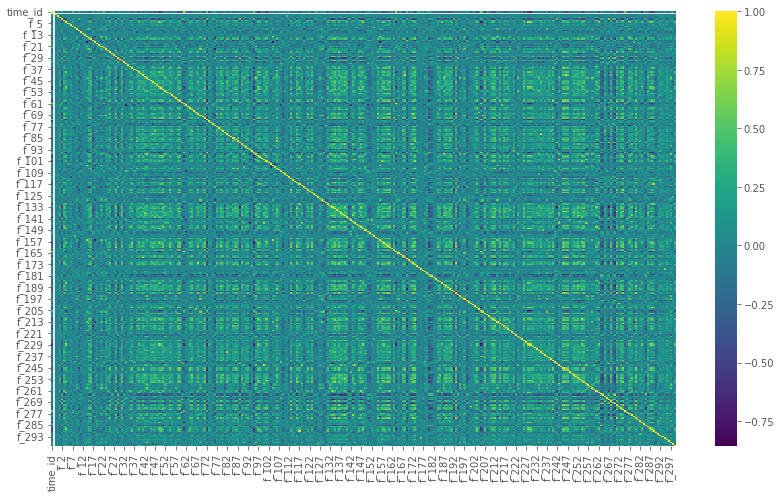

In [13]:
# plot the correlation in a heat map
# Yellow colors indicates a strong correlation
plt.figure(figsize=(14,8))
sns.heatmap(corr,cmap='viridis',annot=False)
plt.xticks(rotation = 90)
plt.show()

## Decomposition with PCA

`Using PCA to find the components with highest explained variance`

In [14]:
# installing and importing the dependencies
!pip install pca
from pca import pca
from sklearn.decomposition import PCA


  Preparing metadata (setup.py) ... - done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=f6a77cbe9bff7614fc97db6349634ff78515ffa50d5d864a15c4950535698ec8
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [15]:
train.head(5)

,row_id,time_id,investment_id,target,f_0,f_1,f_2,f_3,f_4,f_5,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
0,0_1,0.0,1.0,-0.300781,0.932617,0.113708,-0.402100,0.378418,-0.203979,-0.413574,...,0.365967,-1.095703,0.200073,0.819336,0.941406,-0.086792,-1.086914,-1.044922,-0.287598,0.321533
1,0_2,0.0,2.0,-0.231079,0.811035,-0.514160,0.742188,-0.616699,-0.194214,1.771484,...,-0.154175,0.912598,-0.734375,0.819336,0.941406,-0.387695,-1.086914,-0.929688,-0.974121,-0.343506
2,0_6,0.0,6.0,0.568848,0.394043,0.615723,0.567871,-0.607910,0.068909,-1.083008,...,-0.138062,0.912598,-0.551758,-1.220703,-1.060547,-0.219116,-1.086914,-0.612305,-0.113953,0.243652
3,0_7,0.0,7.0,-1.064453,-2.343750,-0.011871,1.875000,-0.606445,-0.586914,-0.815918,...,0.382080,0.912598,-0.266357,-1.220703,0.941406,-0.608887,0.104919,-0.783203,1.151367,-0.773438
4,0_8,0.0,8.0,-0.531738,0.842285,-0.262939,2.330078,-0.583496,-0.618164,-0.742676,...,-0.170410,0.912598,-0.741211,-1.220703,0.941406,-0.588379,0.104919,0.753418,1.345703,-0.737793


In [16]:
# pca
def dim_red(df):
    """ This function extracts the principal components of the features of the data sets
    """
    features = [f'f_{i}' for i in range(300)]
    df_ = df[features]
    
    pca()
    pca_model = pca(n_components=0.90) # explained variance 90%
    results = pca_model.fit_transform(df_)
    
    del df_
    
    return results,pca_model

In [17]:
#  the function obtains the main principal components
results,pca_model = dim_red(df_id1)

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed to capture [90.0%] explained variance using the [300] columns of the input data.
[pca] >Fitting using PCA..
[pca] >Computing loadings and PCs..
[pca] >Computing explained variance..
[pca] >Number of components is [100] that covers the [90.00%] explained variance.
[pca] >The PCA reduction is performed on the [300] columns of the input dataframe.
[pca] >Fitting using PCA..
[pca] >Computing loadings and PCs..
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[100]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


In [18]:
results.keys()

dict_keys(['loadings', 'PC', 'explained_var', 'variance_ratio', 'model', 'scaler', 'pcp', 'topfeat', 'outliers', 'outliers_params'])

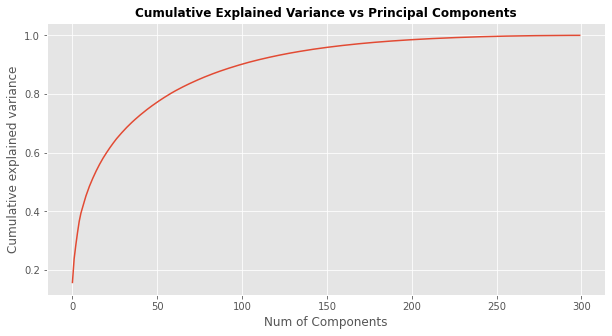

In [19]:
#plot the scree plot to show the components with the most variance in the data set
plt.figure(figsize=(10,5))
plt.title('Cumulative Explained Variance vs Principal Components',fontweight='bold',fontsize=12)
plt.plot(np.cumsum(results['variance_ratio']))
plt.xlabel('Num of Components')
plt.ylabel('Cumulative explained variance')
plt.show()

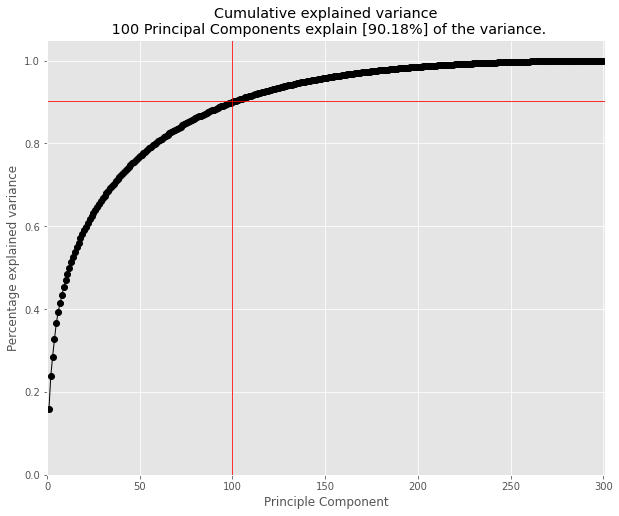

<Figure size 432x288 with 0 Axes>

In [20]:
# plot components/variance
%matplotlib inline
pca_model.plot(figsize=(10,8))
plt.tight_layout()
plt.show()

*From the plots above, 238 components explain 98perc of the features variance. This doesn't solve the problem of dimensionality reduction, and therefore for model training, we are going to use all the features of the data.*

In [21]:
# extracting the features of the df
columns = np.array(train.columns.drop(['row_id', 'time_id', 'investment_id', 'target']))

In [22]:
# targets are the outputs
df_y = train['target']

Mapping integer input tokens into indexed integer output

In [23]:
df_id1.head()

,row_id,time_id,investment_id,target,f_0,f_1,f_2,f_3,f_4,f_5,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
0,0_1,0.0,1.0,-0.300781,0.932617,0.113708,-0.402100,0.378418,-0.203979,-0.413574,...,0.365967,-1.095703,0.200073,0.819336,0.941406,-0.086792,-1.086914,-1.044922,-0.287598,0.321533
2272,1_1,1.0,1.0,-0.916992,0.373535,0.296387,0.019104,-0.031830,-0.222046,-0.199951,...,0.235107,-1.082031,0.645508,0.581055,0.838867,-0.362305,1.229492,-1.300781,-0.391602,0.330322
4547,2_1,2.0,1.0,-0.480225,-0.834473,0.305176,0.057617,-0.193237,-0.174438,0.220581,...,0.069153,-1.283203,0.416504,0.733887,0.708496,-0.318359,1.307617,-0.863770,-0.478760,0.291260
6822,3_1,3.0,1.0,-0.323486,0.351318,0.223877,0.180542,-0.539062,-0.189697,1.441406,...,-0.105713,-1.262695,0.178345,0.766602,0.442627,-0.106201,1.410156,-0.230103,-0.375977,0.249634
9107,4_1,4.0,1.0,2.494141,0.524902,0.076599,-0.102417,-0.527832,-0.186035,2.291016,...,0.988770,-0.583008,0.215942,0.469238,-0.569824,-0.364990,-0.614258,-0.254150,-0.272461,0.299072


Text(0, 0.5, 'f_1')

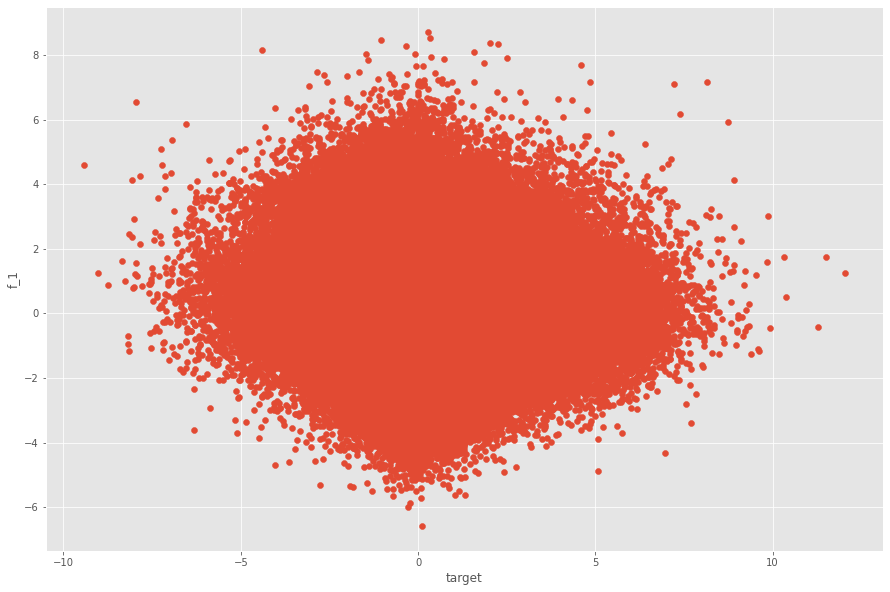

In [24]:
#  plot a  random feature against the target

feature =columns[np.random.randint(0,len(columns))]


plt.figure(figsize=(15, 10))
plt.scatter(train['target'],train['f_1'])
plt.xlabel('target')
plt.ylabel('f_1')

<AxesSubplot:>

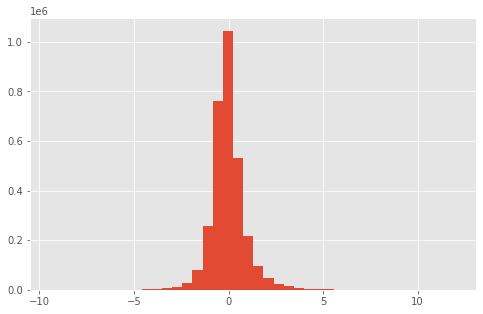

In [25]:
# distribution of targets

plt.figure(figsize=(8, 5))
train['target'].hist(bins=40)

Text(0.5, 1.0, 'f_159')

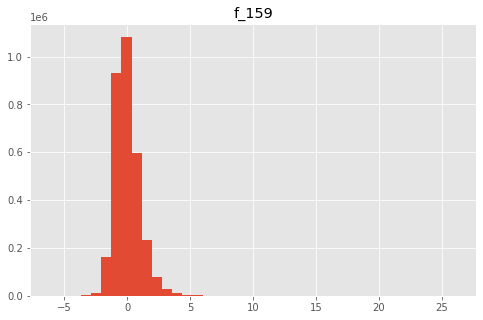

In [26]:
# distribution of random features

plt.figure(figsize=(8, 5))

feature = columns[np.random.randint(0,len(columns))]

train[feature].hist(bins=40)
plt.title(feature)

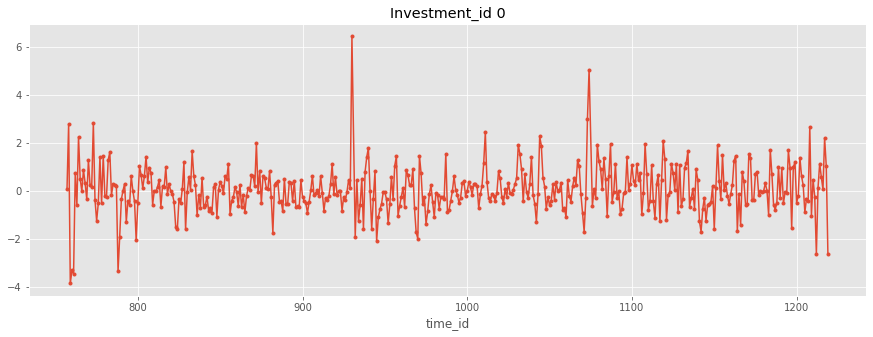

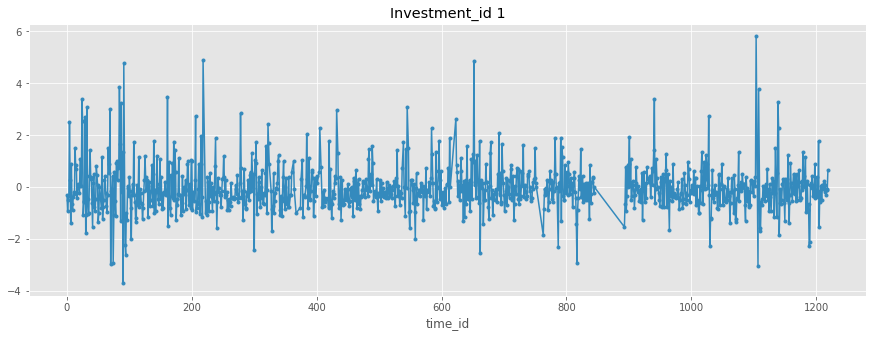

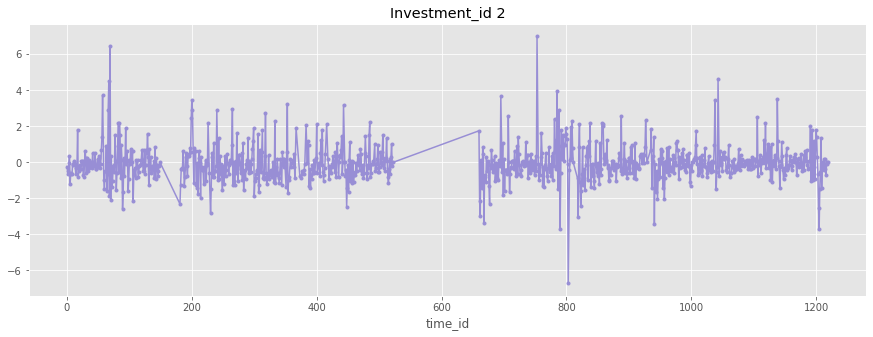

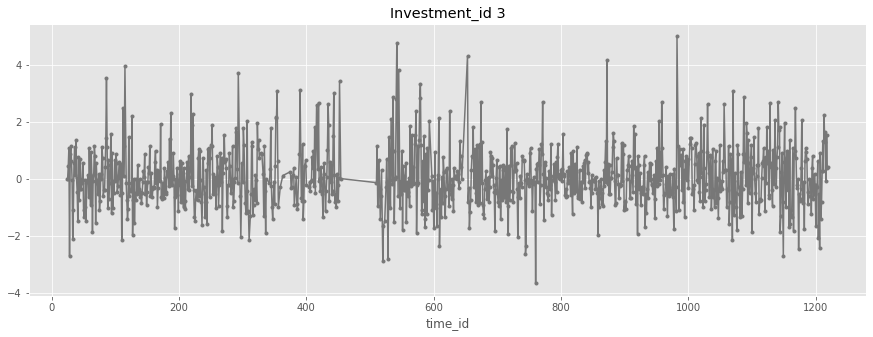

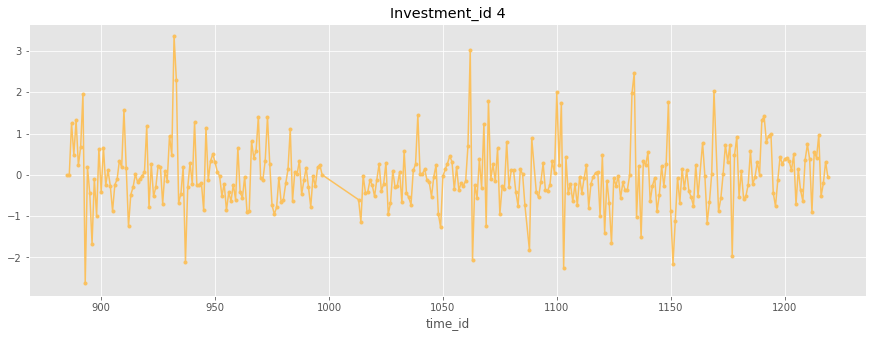

In [27]:
# example target for investment id
for investment_id in range(5):
    d = train.query('investment_id == @investment_id')
    d.set_index('time_id')['target'] \
        .plot(figsize=(15, 5),
              title=f'Investment_id {investment_id}',
              color=next(color_cycle),
              style='.-')
    plt.show()

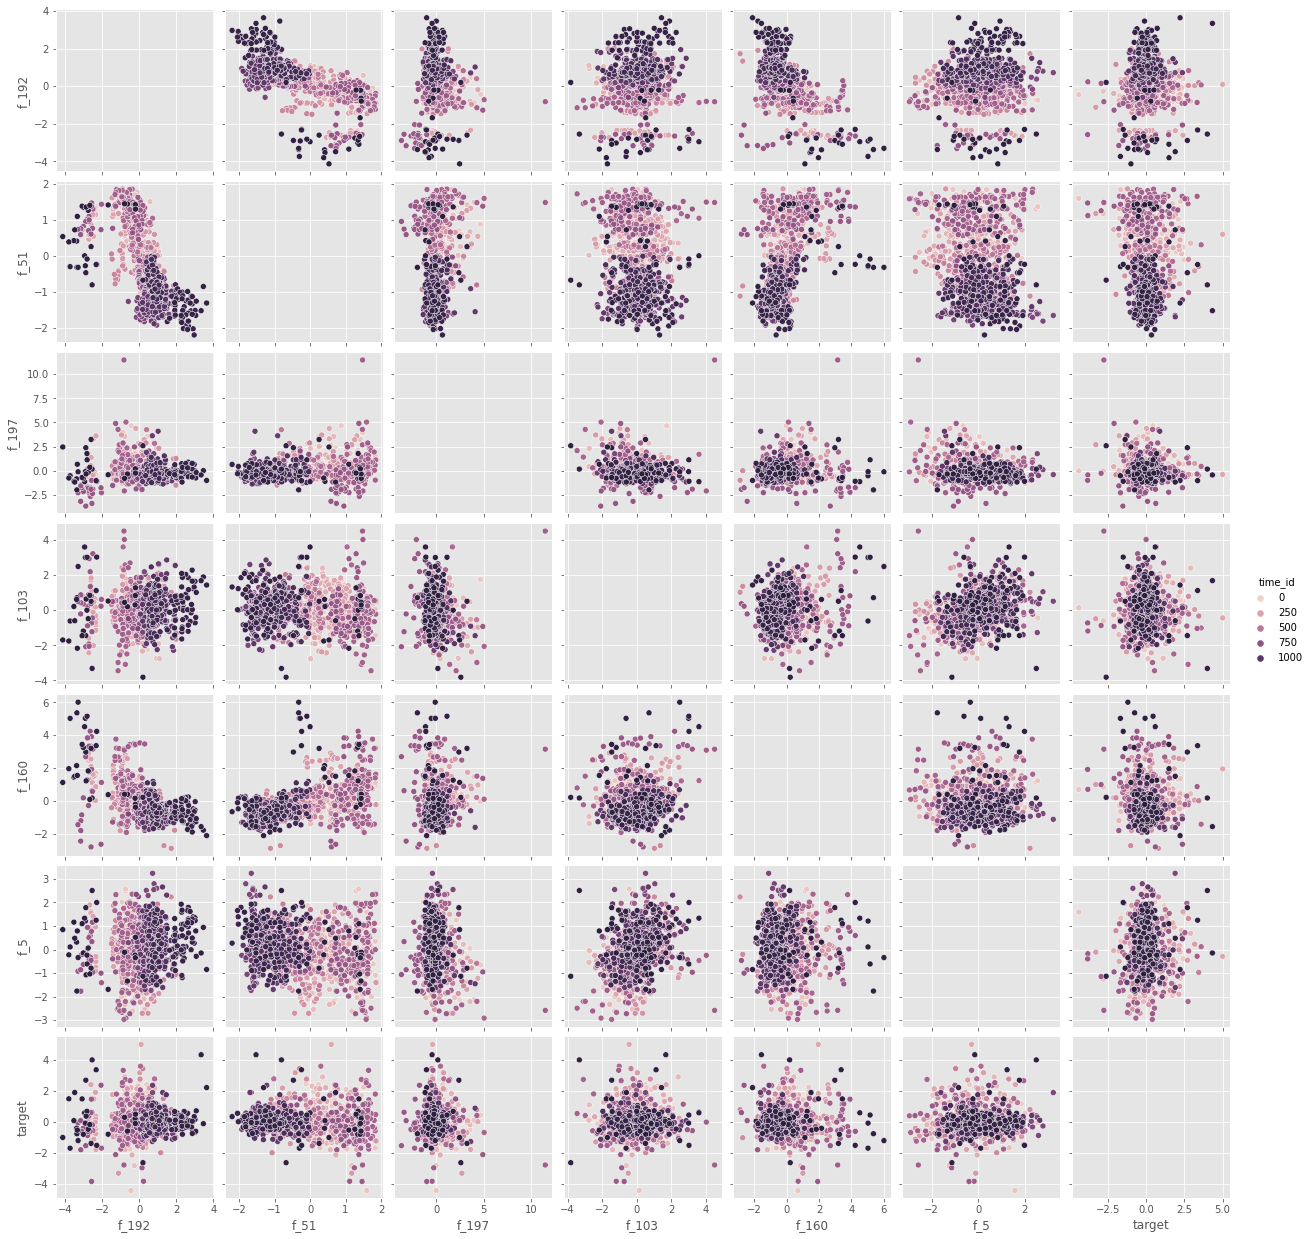

In [28]:
#  a pairplot of 10 random ids in the column section
investment_id = np.random.randint(0, train['investment_id'].nunique())

vars = list(set([columns[np.random.randint(4,len(columns))] for i in range(6)])) + ['target']

example_id = train.query('investment_id == @investment_id')
sns.pairplot(example_id,
             vars=vars,
            hue='time_id')
# diag_kind="hist"

## Determining whether the data is static or non-stationary

In [29]:
# perform autocorrelation of time series data for loading

import statsmodels.api as sm
import statsmodels as smt
import warnings
warnings.filterwarnings("ignore")

# adapted from https://www.kaggle.com/kashnitsky/topic-9-part-1-time-series-analysis-in-python?scriptVersionId=50985180&cellId=80
def tsplot(y, id, lags=None, figsize=(12, 7)):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
           
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    y.plot(ax=ts_ax)
    p_value = sm.tsa.stattools.adfuller(y)[1]
    ts_ax.set_title(f'Investment_id{id}\nTime Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
    smt.graphics.tsaplots.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.tsaplots.plot_pacf(y, lags=lags, ax=pacf_ax)
    plt.tight_layout()
    

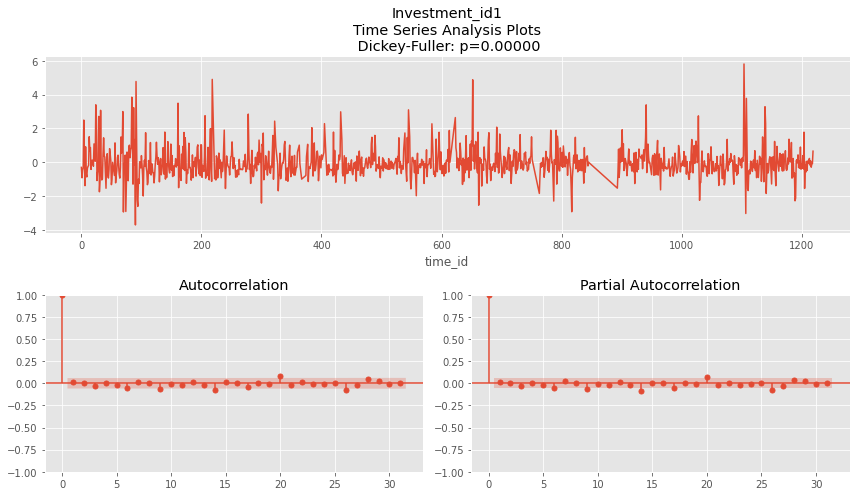

In [30]:
df_id1=df_id1.set_index('time_id')
target = df_id1['target']
tsplot(target,id=1)

`The Dickey Fuller p value < 0.5% making the series to be more likely stationary. The Autocorrelation factor (ACF) is helpful in determing whether the data is static or not .
Non stationary data exhibit a trend or pattern. The data of investment_id behaves like a random noise`

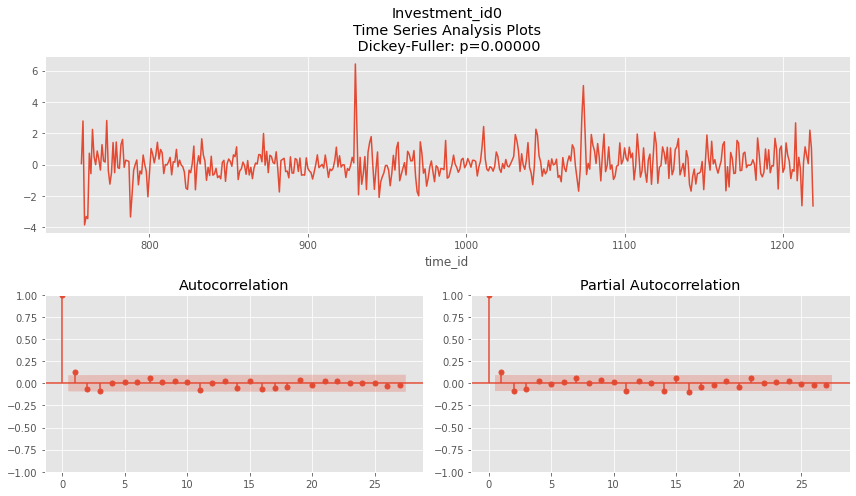

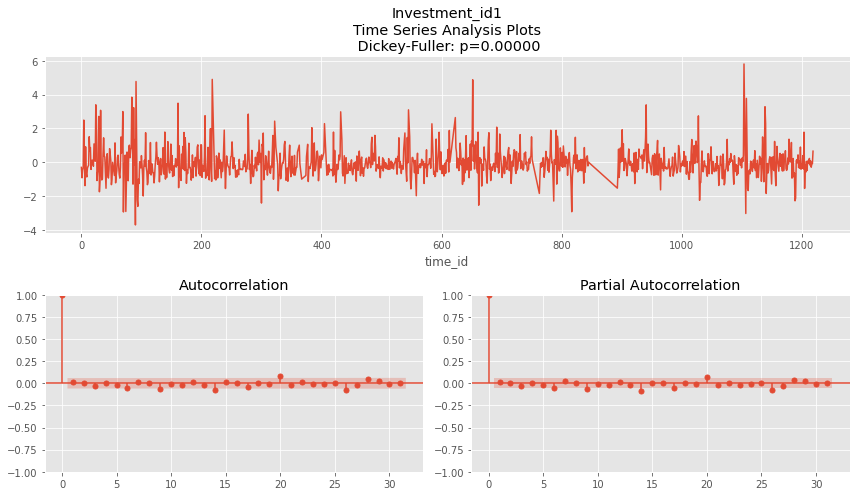

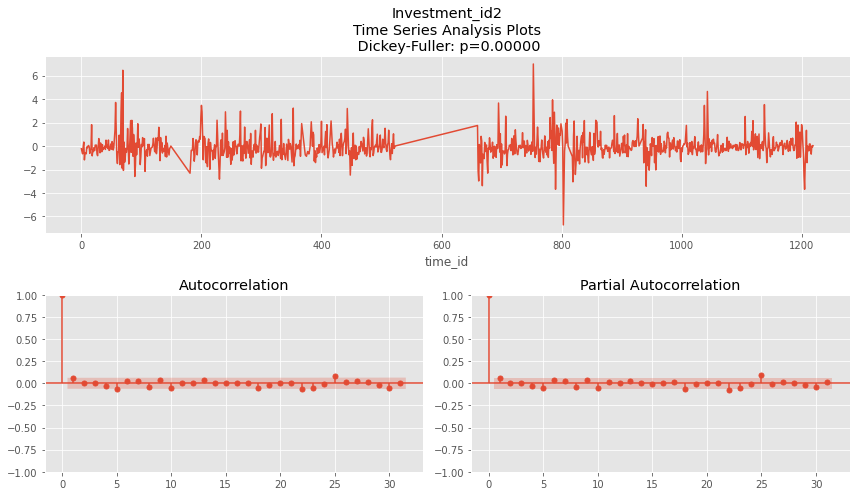

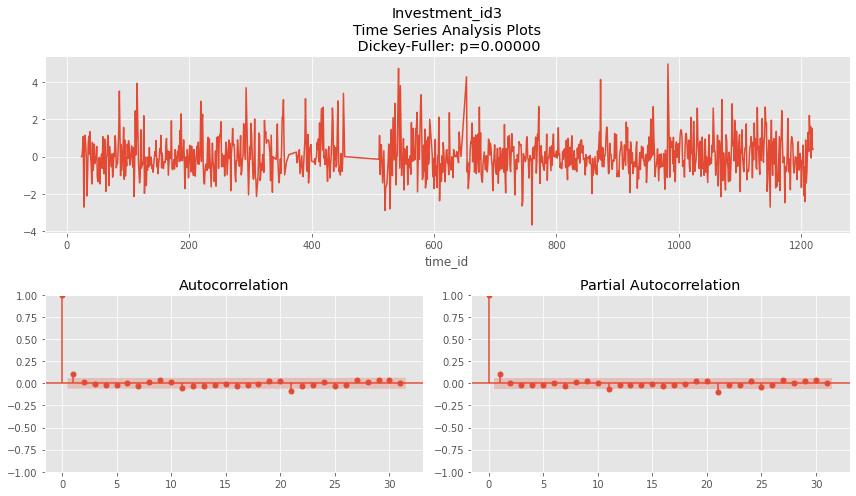

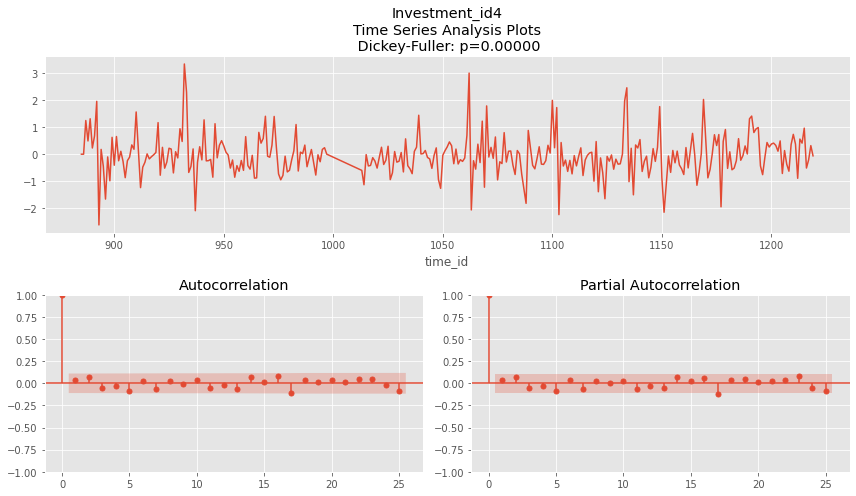

In [31]:
# plots the acf of the first five investment_ids - 
for i in range(5):
    df__ = train.query('investment_id == @i')
    df__=df__.set_index('time_id')
    target = df__['target']
    tsplot(target,id=i)


## Data preparation for loading
* Standardization of the investment id -  to minimize loss

In [32]:
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import KFold, train_test_split

In [33]:
def data_prep(df):
    
    """
    This is preliminary data preprocessing for training. The function extracts the investment ids
    fro the train datasets, and scale the data to minimize losses during the traing.
    
    Due to memory exhaustion, unusued dataframes are recursively deleted.
    """
    
    scaler = StandardScaler()
    features = ['investment_id']+[f'f_{i}' for i in range(300)]
    df_ = df[features]
    df_x = scaler.fit_transform(df_)

    del df_
    
    return df_x


In [34]:
def data_prep_(df):
    
    """
    This is preliminary data preprocessing for training. The function extracts the investment ids
    fro the train datasets, and scale the data to minimize losses during the traing.
    
    Due to memory exhaustion, unusued dataframes are recursively deleted.
    """
    
    scaler = StandardScaler()
    features = ['investment_id']+[f'f_{i}' for i in range(300)]
    df_ = df[features]
    df_x = scaler.fit_transform(df_)
    df_x = df_x.reshape(-1,301,1,1)

    del df_
    
    return df_x

In [35]:
# scale data  for processing
df_x = data_prep(train)

# del train for efficient memory utility
# del train

In [36]:
df_dummy_x = train[:1000000]
df_dummy_y = df_y[:1000000]

In [37]:
# create a dataframe for the training
# df_dummy_x = data_prep_(df_dummy_x)
df_x = data_prep_(train)
del train

In [38]:
# Work on training the model
# use of convolution neural network to reduce feature dimensions and train the model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten,Dense,Conv2D, Conv1D,MaxPool1D,MaxPool2D,LSTM, Dropout,BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

## ConvDNN Model Architecture

In [39]:
# conv2d model
def basic_conv2D():
    """
    This is a basic convolution neural network set up with an input dim of length equal to training features.
    The output of a conv2d, is flattened and inputs to a dense neural network for prediction.
    
    Since, this is a regression task loss computed as a square of distances and optimized with adapative momentum.
    """
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size = 2, padding='same', activation='relu', input_shape=(301,1,1)))
    model.add(MaxPool2D(pool_size=(3,3),strides=2,padding='same'))
    model.add(Flatten())
    model.add(Dense(400, activation=tf.keras.activations.relu))
    model.add(BatchNormalization())
    model.add(Dropout(rate = 0.01))
    model.add(Dense(500, activation=tf.keras.activations.relu))
    model.add(BatchNormalization())
    model.add(Dropout(rate = 0.01))
    model.add(Dense(800, activation=tf.keras.activations.relu))
    model.add(BatchNormalization())
    model.add(Dropout(rate = 0.01))
    model.add(Dense(500, activation=tf.keras.activations.relu))
    model.add(BatchNormalization())
    model.add(Dropout(rate = 0.01))
    model.add(Dense(400, activation=tf.keras.activations.relu))
    model.add(BatchNormalization())
    model.add(Dropout(rate = 0.01))
    model.add(Dense(128, activation=tf.keras.activations.relu))
    model.add(BatchNormalization())
    model.add(Dropout(rate = 0.01))
    model.add(Dense(8, activation=tf.keras.activations.relu))
    model.add(BatchNormalization())
    model.add(Dropout(rate = 0.01))
    model.add((Dense(1)))

    
    model.compile(metrics=[RootMeanSquaredError()],optimizer=Adam(learning_rate=0.0001), loss=MeanSquaredError()) 
    
    return model

m2 = basic_conv2D()

m2.summary()

2022-02-26 00:06:08.088328: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-26 00:06:08.215202: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-26 00:06:08.216058: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-26 00:06:08.218998: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 301, 1, 32)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 151, 1, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 4832)              0         
_________________________________________________________________
dense (Dense)                (None, 400)               1933200   
_________________________________________________________________
batch_normalization (BatchNo (None, 400)               1600      
_________________________________________________________________
dropout (Dropout)            (None, 400)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 500)               2

In [40]:
# model training


kfold_generator = KFold(n_splits =5, shuffle=True, random_state =2022)
cp1 = ModelCheckpoint('m2', save_best_only=True)
for train_index, val_index in kfold_generator.split(df_x, df_y):
    # Split training dataset.
    train_x, train_y = df_x[train_index], df_y.iloc[train_index]
    # Split validation dataset.
    val_x, val_y = df_x[val_index], df_y.iloc[val_index]
#     Make data as arrays
    tf_train = tf.data.Dataset.from_tensor_slices((train_x, train_y)).shuffle(2022).batch(1024, drop_remainder=True).prefetch(1)
    del train_x
    del train_y
    print('deleted train_x and train_y')
    tf_val = tf.data.Dataset.from_tensor_slices((val_x, val_y)).shuffle(2022).batch(1024, drop_remainder=True).prefetch(1)
    del val_y
    del val_x
    
    
    m2 = basic_conv2D()
    
    m2.fit(tf_train, validation_data=(tf_val), epochs=10, callbacks=cp1)
    
    del tf_train
    del tf_val
    del m2

2022-02-26 00:06:13.054155: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1512903056 exceeds 10% of free system memory.
2022-02-26 00:06:14.641225: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1512903056 exceeds 10% of free system memory.


deleted train_x and train_y


2022-02-26 00:06:16.541596: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1512903056 exceeds 10% of free system memory.
2022-02-26 00:06:17.456176: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1512903056 exceeds 10% of free system memory.


Epoch 1/10


2022-02-26 00:06:19.619016: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-26 00:06:20.681399: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


2454/2454 [==============================] - 38s 12ms/step - loss: 0.8731 - root_mean_squared_error: 0.9344 - val_loss: 0.8488 - val_root_mean_squared_error: 0.9213


2022-02-26 00:06:57.760251: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-02-26 00:07:00.415463: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1512903056 exceeds 10% of free system memory.


Epoch 2/10
2454/2454 [==============================] - 30s 12ms/step - loss: 0.8465 - root_mean_squared_error: 0.9200 - val_loss: 0.8476 - val_root_mean_squared_error: 0.9207
Epoch 3/10
2454/2454 [==============================] - 30s 12ms/step - loss: 0.8432 - root_mean_squared_error: 0.9182 - val_loss: 0.8454 - val_root_mean_squared_error: 0.9195
Epoch 4/10
2454/2454 [==============================] - 31s 13ms/step - loss: 0.8406 - root_mean_squared_error: 0.9168 - val_loss: 0.8427 - val_root_mean_squared_error: 0.9180
Epoch 5/10
2454/2454 [==============================] - 30s 12ms/step - loss: 0.8375 - root_mean_squared_error: 0.9151 - val_loss: 0.8428 - val_root_mean_squared_error: 0.9181
Epoch 6/10
2454/2454 [==============================] - 30s 12ms/step - loss: 0.8348 - root_mean_squared_error: 0.9137 - val_loss: 0.8408 - val_root_mean_squared_error: 0.9170
Epoch 7/10
2454/2454 [==============================] - 30s 12ms/step - loss: 0.8328 - root_mean_squared_error: 0.9126 -

## Make inference